# Brain Tumor Detection Using a Convolutional Neural Network

**About the Brain MRI Images dataset:**<br>
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous and the folder no contains 98 Brain MRI Images that are non-tumorous. You can find it [here](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection).

## Import Necessary Modules

In [1]:
import tensorflow as tf 
import keras as keras
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In order to crop the part that contains only the brain of the image, I used a cropping technique to find the extreme top, bottom, left and right points of the brain. You can read more about it here [Finding extreme points in contours with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/).

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

In order to better understand what it's doing, let's grab an image from the dataset and apply this cropping function to see the result:

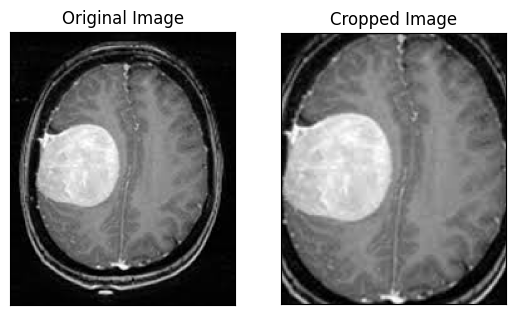

In [3]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following: 
1. Read the image.
2. Crop the part of the image representing only the brain.
3. Resize the image (because the images in the dataset come in different sizes (meaning width, height and # of channels). So, we want all of our images to be (240, 240, 3) to feed it as an input to the neural network.
4. Apply normalization because we want pixel values to be scaled to the range 0-1.
5. Append the image to <i>X</i> and its label to <i>y</i>.<br>

After that, Shuffle <i>X</i> and <i>y</i>, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).<br>
Finally, Return <i>X</i> and <i>y</i>.

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

Load up the data that we augmented earlier in the Data Augmentation notebook.<br>
**Note:** the augmented data directory contains not only the new generated images but also the original images.

In [5]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


As we see, we have 2065 images. Each images has a shape of **(240, 240, 3)=(image_width, image_height, number_of_channels)**

### Plot sample images:

In [6]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

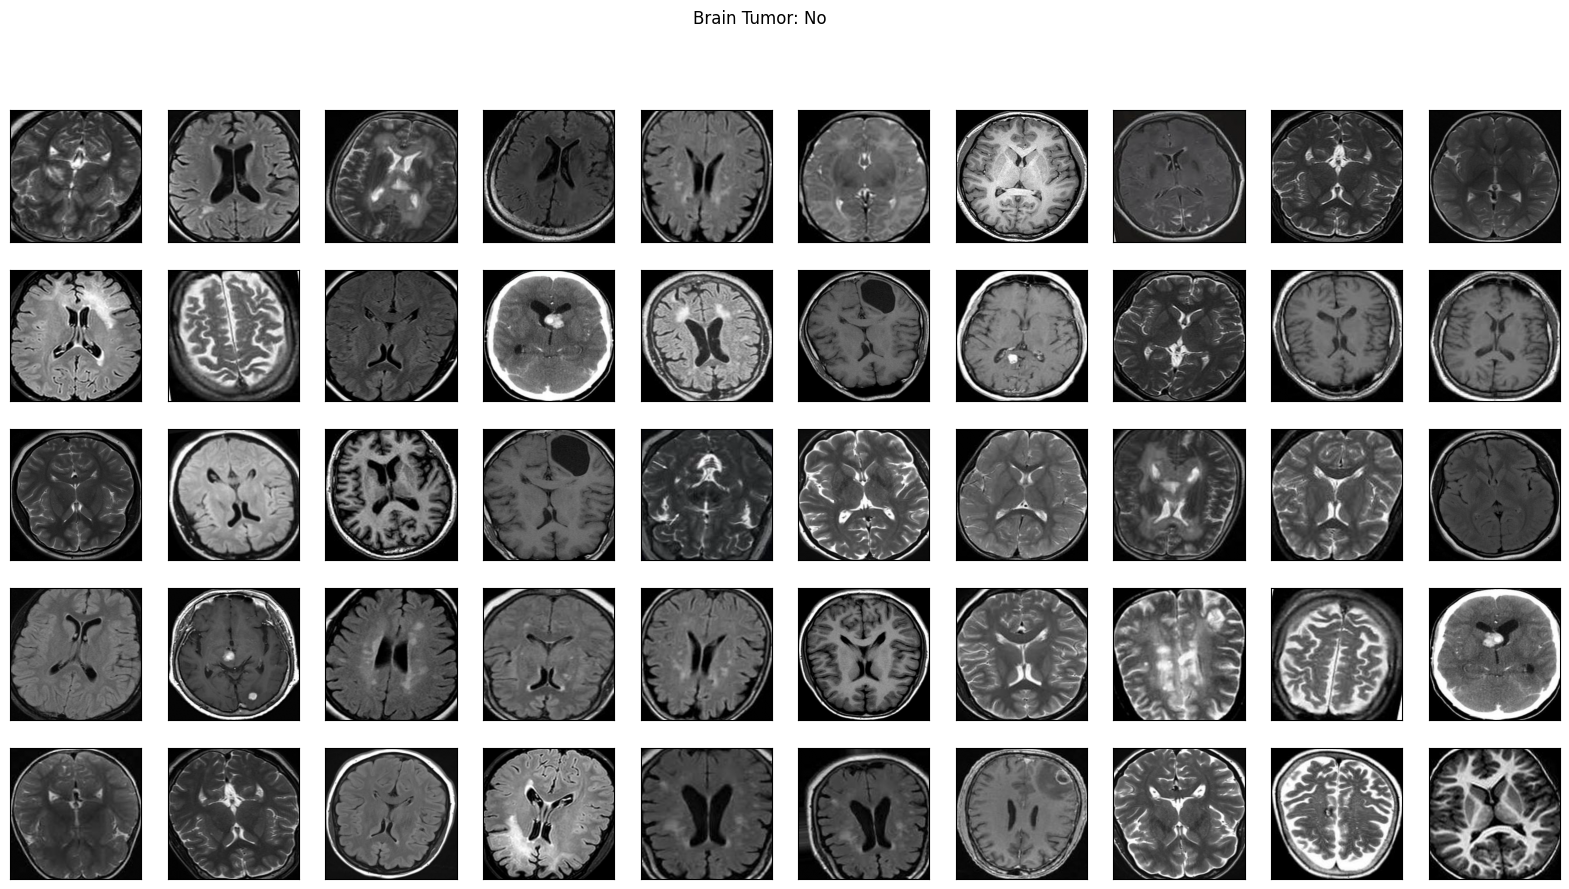

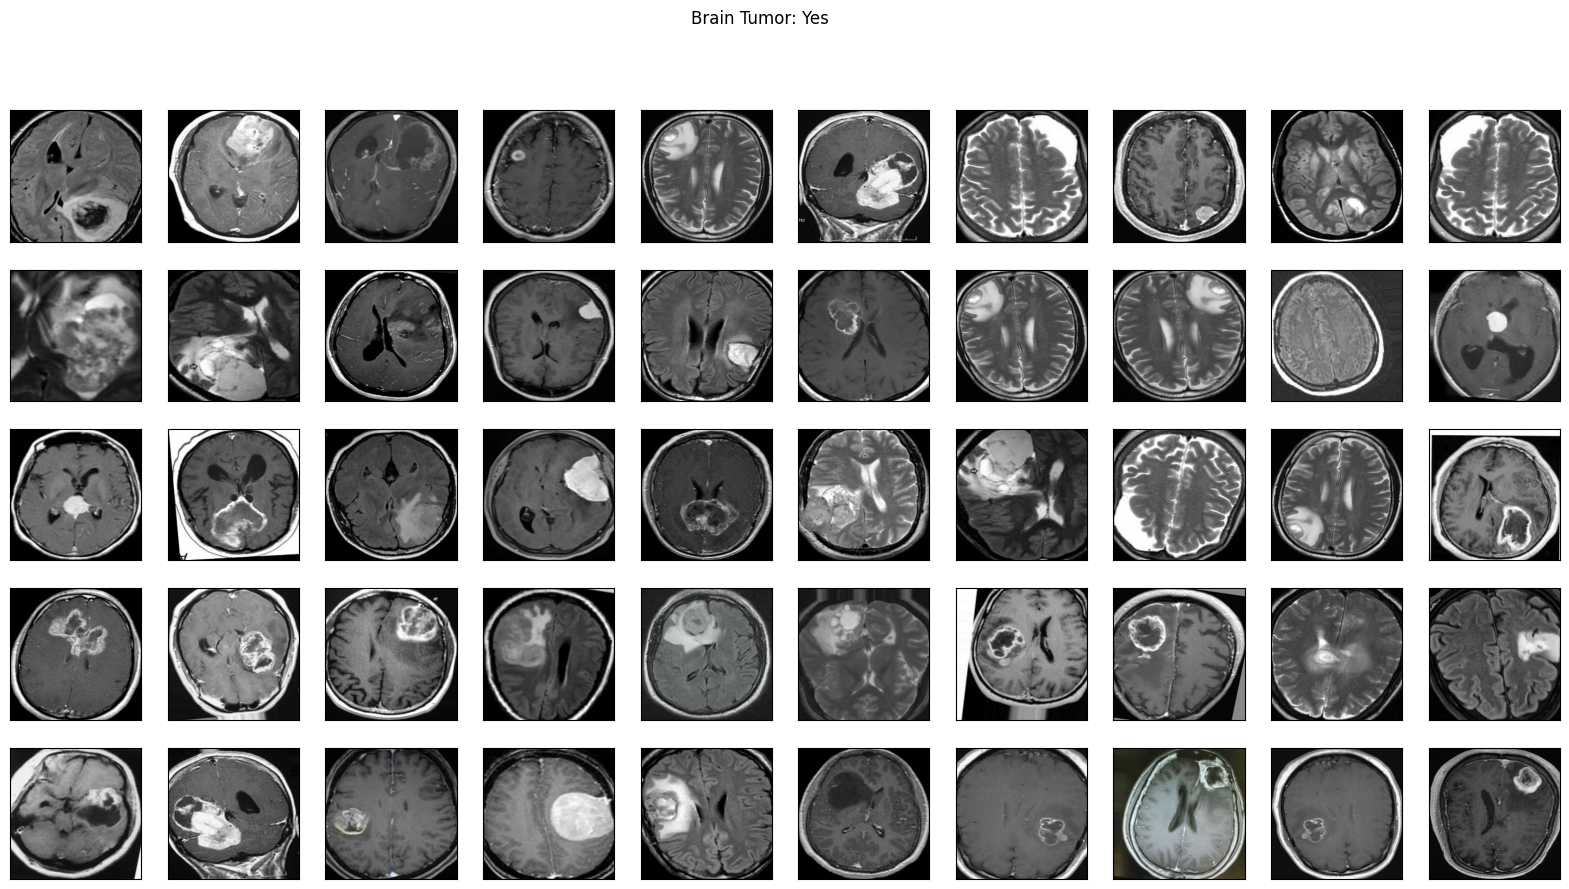

In [7]:
plot_sample_images(X, y)

### Split the data:
Split <i>X</i> and <i>y</i> into training, validation (development) and validation sets.

In [8]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

Let's use the following way to split:<br>
1. 70% of the data for training.
2. 15% of the data for validation.
3. 15% of the data for testing.

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [10]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [11]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [12]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

Let's build a convolutional neural network model:

<img src='convnet_architecture.jpg'>

In [13]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [14]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [15]:
model = build_model(IMG_SHAPE)

In [16]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

Compile the model:

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [19]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [20]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 0.8404 - accuracy: 0.6228

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.63.model\assets


46/46 [==============================] - 111s 2s/step - loss: 0.8404 - accuracy: 0.6228 - val_loss: 0.6444 - val_accuracy: 0.6290
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.7585

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.68.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.68.model\assets


46/46 [==============================] - 110s 2s/step - loss: 0.5129 - accuracy: 0.7585 - val_loss: 0.6107 - val_accuracy: 0.6839
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.4579 - accuracy: 0.7862

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.80.model\assets


46/46 [==============================] - 105s 2s/step - loss: 0.4579 - accuracy: 0.7862 - val_loss: 0.5491 - val_accuracy: 0.8032
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.3861 - accuracy: 0.8360

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.76.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.76.model\assets


46/46 [==============================] - 96s 2s/step - loss: 0.3861 - accuracy: 0.8360 - val_loss: 0.5200 - val_accuracy: 0.7581
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.3660 - accuracy: 0.8436

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.78.model\assets


46/46 [==============================] - 95s 2s/step - loss: 0.3660 - accuracy: 0.8436 - val_loss: 0.4992 - val_accuracy: 0.7806
Epoch 6/10
46/46 [==============================] - ETA: 0s - loss: 0.3261 - accuracy: 0.8616

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.81.model\assets


46/46 [==============================] - 111s 2s/step - loss: 0.3261 - accuracy: 0.8616 - val_loss: 0.4326 - val_accuracy: 0.8129
Epoch 7/10
46/46 [==============================] - ETA: 0s - loss: 0.2930 - accuracy: 0.8907

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.59.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.59.model\assets


46/46 [==============================] - 104s 2s/step - loss: 0.2930 - accuracy: 0.8907 - val_loss: 0.7625 - val_accuracy: 0.5935
Epoch 8/10
46/46 [==============================] - ETA: 0s - loss: 0.3476 - accuracy: 0.8526

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.83.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.83.model\assets


46/46 [==============================] - 99s 2s/step - loss: 0.3476 - accuracy: 0.8526 - val_loss: 0.4097 - val_accuracy: 0.8290
Epoch 9/10
46/46 [==============================] - ETA: 0s - loss: 0.2797 - accuracy: 0.8927

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.82.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.82.model\assets


46/46 [==============================] - 101s 2s/step - loss: 0.2797 - accuracy: 0.8927 - val_loss: 0.3774 - val_accuracy: 0.8161
Epoch 10/10
46/46 [==============================] - ETA: 0s - loss: 0.2708 - accuracy: 0.8948

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.86.model\assets


46/46 [==============================] - 104s 2s/step - loss: 0.2708 - accuracy: 0.8948 - val_loss: 0.3400 - val_accuracy: 0.8613
Elapsed time: 0:17:17.0


Let's train for a few more epochs:

In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.2107 - accuracy: 0.9239

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.84.model\assets


46/46 [==============================] - 104s 2s/step - loss: 0.2107 - accuracy: 0.9239 - val_loss: 0.3479 - val_accuracy: 0.8387
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9163

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.84.model\assets


46/46 [==============================] - 104s 2s/step - loss: 0.2038 - accuracy: 0.9163 - val_loss: 0.4235 - val_accuracy: 0.8387
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9156

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.80.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.80.model\assets


46/46 [==============================] - 103s 2s/step - loss: 0.2186 - accuracy: 0.9156 - val_loss: 0.4880 - val_accuracy: 0.8000
Elapsed time: 0:5:15.8


In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.9232

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.85.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.85.model\assets


46/46 [==============================] - 115s 2s/step - loss: 0.1954 - accuracy: 0.9232 - val_loss: 0.3662 - val_accuracy: 0.8452
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1566 - accuracy: 0.9474

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.86.model\assets


46/46 [==============================] - 112s 2s/step - loss: 0.1566 - accuracy: 0.9474 - val_loss: 0.3177 - val_accuracy: 0.8581
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1794 - accuracy: 0.9384

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.87.model\assets


46/46 [==============================] - 115s 2s/step - loss: 0.1794 - accuracy: 0.9384 - val_loss: 0.2979 - val_accuracy: 0.8742
Elapsed time: 0:5:43.5


In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9612

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.88.model\assets


46/46 [==============================] - 209s 5s/step - loss: 0.1264 - accuracy: 0.9612 - val_loss: 0.2917 - val_accuracy: 0.8774
Epoch 2/3
46/46 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9474

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.82.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.82.model\assets


46/46 [==============================] - 135s 3s/step - loss: 0.1420 - accuracy: 0.9474 - val_loss: 0.4783 - val_accuracy: 0.8161
Epoch 3/3
46/46 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9571

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.89.model\assets


46/46 [==============================] - 106s 2s/step - loss: 0.1301 - accuracy: 0.9571 - val_loss: 0.2995 - val_accuracy: 0.8871
Elapsed time: 0:7:30.7


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

In [25]:
history = model.history.history

In [26]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


## Plot Loss & Accuracy

In [27]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

**Note:** Since we trained the model using more than model.fit() function call, this made the history only contain the metric values of the epochs for the last call (which was for 5 epochs), so to plot the metric values across the whole process of trianing the model from the beginning, I had to grab the rest of the values. 

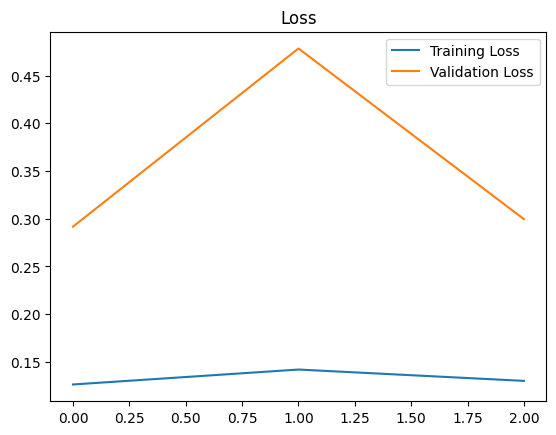

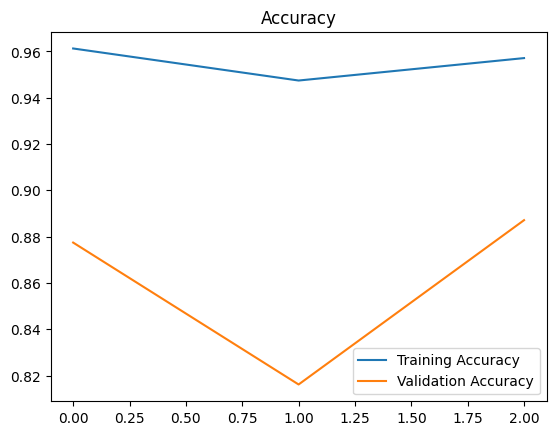

In [28]:
plot_metrics(history) 

# Results

Let's experiment with the best model (the one with the best validation accuracy):

Concretely, the model at the 23rd iteration with validation accuracy of 91%

### Load the best model

In [29]:
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [30]:
best_model.metrics_names

['loss', 'accuracy']

Evaluate the best model on the testing data:

In [31]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

10/10 [==============================] - 5s 474ms/step - loss: 0.1500 - accuracy: 0.9645


### Accuracy of the best model on the testing data:

In [32]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.15000039339065552
Test Accuracy = 0.9645161032676697


### F1 score for the best model on the testing data:

In [33]:
y_test_prob = best_model.predict(X_test)

10/10 [==============================] - 5s 475ms/step


In [35]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9671641791044776


Let's also find the f1 score on the validation data:

In [36]:
y_val_prob = best_model.predict(X_val)

10/10 [==============================] - 3s 329ms/step


In [37]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9581993569131834


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [38]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [39]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [40]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.24913494809689%, number of pos examples: 755
Percentage of negative examples: 47.75086505190311%, number of neg examples: 690
Validation Data:
Number of examples: 310
Percentage of positive examples: 51.29032258064516%, number of pos examples: 159
Percentage of negative examples: 48.70967741935484%, number of neg examples: 151
Testing Data:
Number of examples: 310
Percentage of positive examples: 55.16129032258065%, number of pos examples: 171
Percentage of negative examples: 44.83870967741935%, number of neg examples: 139


As expectred, the percentage of positive examples are around 50%.

# Conclusion:

#### Now, the model detects brain tumor with:<br>
**88.7%** accuracy on the **test set**.<br>
**0.88** f1 score on the **test set**.<br>
These resutls are very good considering that the data is balanced.

**Performance Table:**

| <!-- -->  | Validation set | Test set |
| --------- | -------------- | -------- |
| Accuracy  | 91%            | 89%      |
| F1 score  | 0.91           | 0.88     |

Hooray!